In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from astropy import units,constants

from tqdm import tqdm

In [2]:
from src import utils,physics,nsphere,run_units
from src.density.nfw import NFW
from src.density.hernquist import Hernquist
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.background import Mass_Distribution

# Constants and general functions

In [3]:
Mtot_dm = units.Quantity(1.15e9,'Msun')
# Mtot_dm = units.Quantity(1.15e10,'Msun')
Mtot_b = units.Quantity(1e5,'Msun')
Rs = units.Quantity(1.18,'kpc')
# Rs = units.Quantity(0.715,'kpc')
c = 17
# c = 19
sigma = units.Quantity(50,'cm^2/gram')
# sigma = units.Quantity(0,'cm^2/gram')

# Setup - DM

In [4]:
dm_n_particles = 1e5
dm_density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,unit_mass=Mtot_dm/dm_n_particles)
dt = dm_density.Tdyn / 1000
save_every_time = 10*dm_density.Tdyn

halo = Halo.setup(densities=[dm_density],n_particles=[dm_n_particles],particle_types=[0],dt=dt,save_every_time=save_every_time,
                  scatter_params = {'max_allowed_rounds':100,'kappa':0.002,'random_round_rounding':False,'sigma':sigma},scatter_every_n_steps=50)

In [5]:
# halo.evolve(t=units.Quantity(20,'Gyr'))
halo.evolve(t=units.Quantity(3,'Gyr'))
# halo.evolve(t=units.Quantity(1,'Gyr'))

  0%|▏                                                              | 351/168337 [00:36<4:54:14,  9.52it/s]

KeyboardInterrupt



In [6]:
halo.save()

## Scatter plots

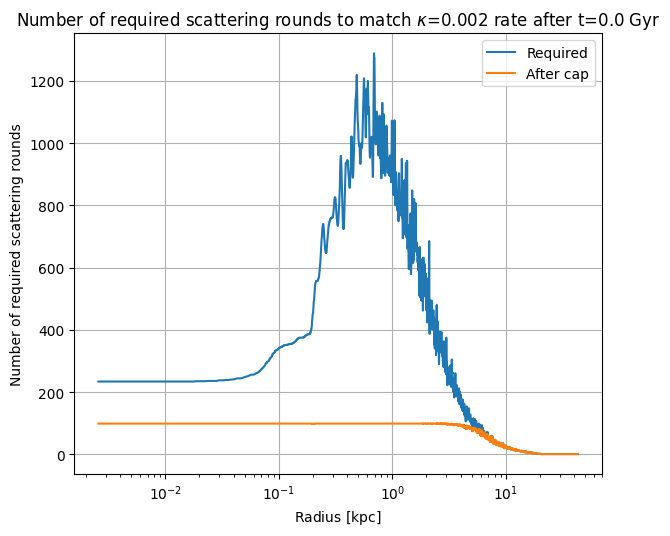

In [5]:
halo.plot_required_scatter_rounds(ax_set={'xscale':'log'});

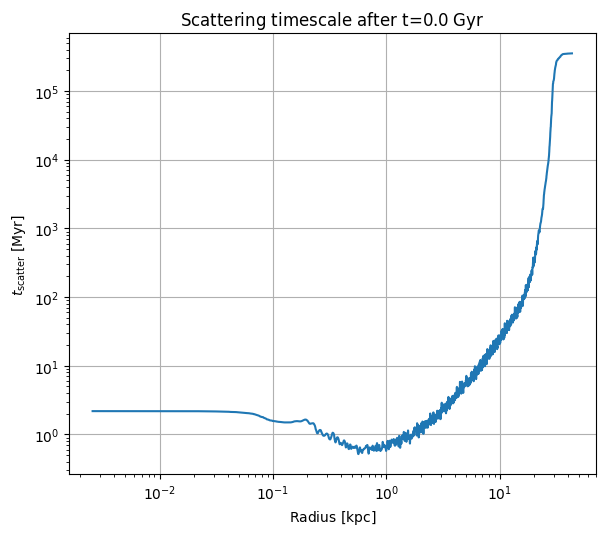

In [10]:
halo.plot_scattering_timescale(ax_set={'xscale':'log','yscale':'log'});

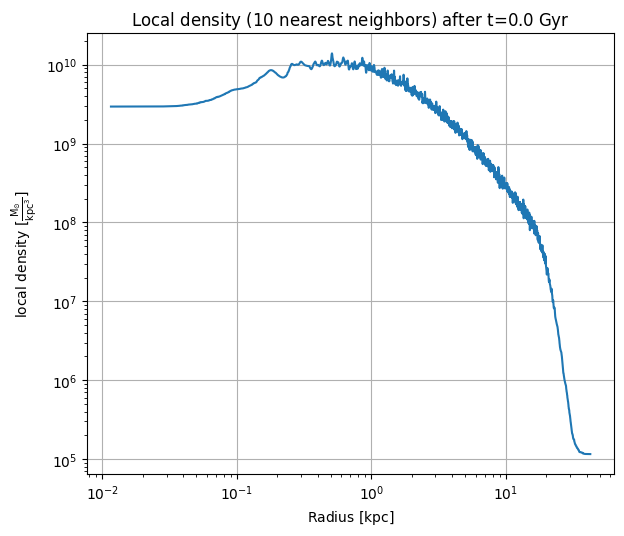

In [13]:
halo.plot_local_density(ax_set={'xscale':'log','yscale':'log'});

## Analysis

In [7]:
print(halo.print_energy_change_summary())

After 1122249 steps with dt=0.0178 Myr | 20000.0 Myr
        Total energy at the start:      199969.8 kpc2 solMass / Myr2
        Total energy at the end:        37986.8 kpc2 solMass / Myr2
        Energy change:                  161983.1 kpc2 solMass / Myr2
        Energy change per step:         1.4e-01 kpc2 solMass / Myr2
        Energy change per dt:           9.1e+06 kpc2 solMass / Myr3
        Relative energy change:         81.004%
        Mean velocity change:           8.0 km / s
        Mean velocity change per step:  7.1e-06 km / s
        Mean velocity change per dt:    4.5e+02 km / (Myr s)
        Relative Mean velocity change:  42.522%


In [9]:
halo.plot_scattering_density(time_units='Gyr',length_units='kpc');

KeyboardInterrupt: 

In [ ]:
halo.plot_scattering_location(time_units='Myr',length_units='kpc');

In [ ]:
halo.plot_r_density_over_time(clip=units.Quantity([0,70],'kpc'));

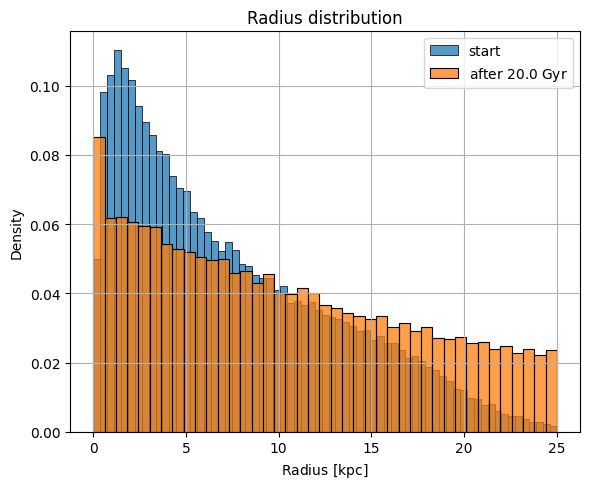

In [11]:
halo.plot_before_after_histogram(key='r',x_units='kpc',time_units='Gyr',x_range=units.Quantity([0,25],'kpc'));

In [ ]:
halo.plot_before_after_histogram(key='r',x_units='kpc',time_units='Gyr');

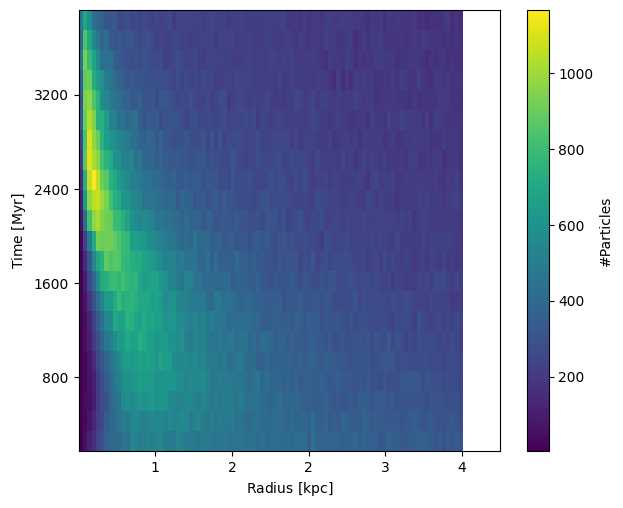

In [21]:
halo.plot_density_evolution(time_units='Myr',time_range=units.Quantity([0,4],'Gyr'),radius_range=units.Quantity([0,4],'kpc'));

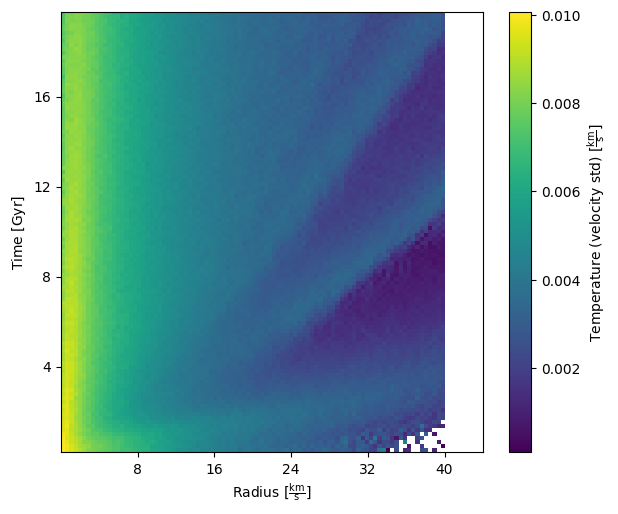

In [9]:
halo.plot_temperature(time_units='Gyr');

In [16]:
halo.scatter_every_n_steps*halo.dt

<Quantity 0.89106653 Myr>

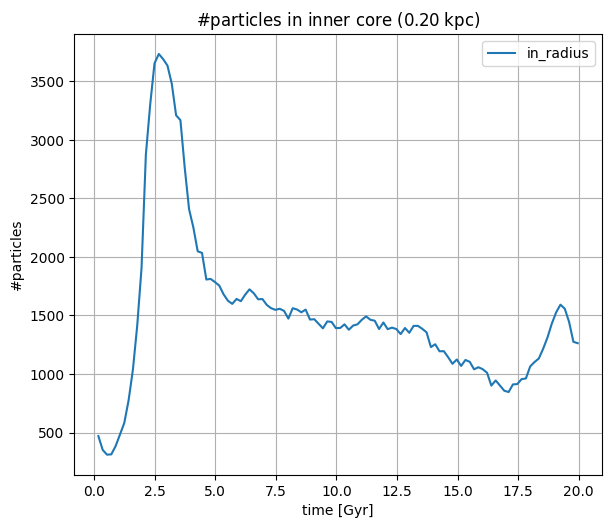

In [13]:
halo.plot_inner_core_density(radius=0.2*units.kpc,time_units='Gyr');

In [80]:
from pdf2image import convert_from_path
import PIL
from pathlib import Path

In [85]:
dpi = 300
file_path = Path('/home/rotembarnea/Downloads/2024_Moed B _Master.pdf')
images = convert_from_path(file_path,dpi=dpi)
cleaned_images = []
for image in tqdm(images):
    cleaned = np.array(image)
    cleaned[:,:,2] = 255
    cleaned = np.mean(cleaned, axis=2)
    threshold = 200
    cleaned = (cleaned > threshold).astype(np.uint8) * 255
    cleaned = np.stack([cleaned]*3,axis=2)
    cleaned = PIL.Image.fromarray(cleaned)
    cleaned_images += [cleaned]
cleaned_images[0].save(file_path.with_stem(f'{file_path.stem}___cleaned'),format='PDF',save_all=True,
                       append_images=cleaned_images[1:],resolution=dpi)

100%|██████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.08it/s]


# Setup - B matter

In [9]:
n_particles = int(1e5)
dm_density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,unit_mass=Mtot_dm/n_particles)
density = Hernquist(Rs=Rs,Mtot=Mtot_b,unit_mass=Mtot_b/n_particles)
density.Tdyn = dm_density.Tdyn
steps_per_Tdyn = 1000
total_run_time = 1100 * density.Tdyn
save_every = 10*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=0,save_every=save_every,
                  total_run_time=total_run_time,mass_calculation_method='lattice')
halo.add_background(Mass_Distribution.from_files(halo.lattice,Mtot=Mtot_dm,base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
                                                 max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data'))

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:02<00:00, 180.20it/s]


In [8]:
# halo.reset()
halo.evolve(n_Tdyn=1100)
# halo.evolve(n_Tdyn=81)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

100%|███████████████████████████████████████████████████████████| 1100000/1100000 [44:02<00:00, 416.32it/s]


In [13]:
halo.saved_states.to_csv('states dm.csv')

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

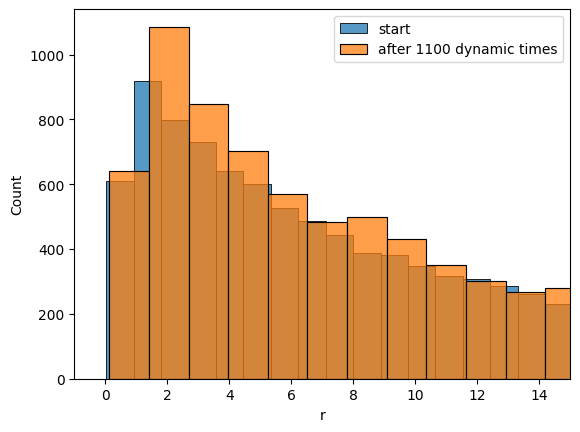

In [14]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)
ax.set_xlim((-1,15))
ax.legend(['start','after 1100 dynamic times'])

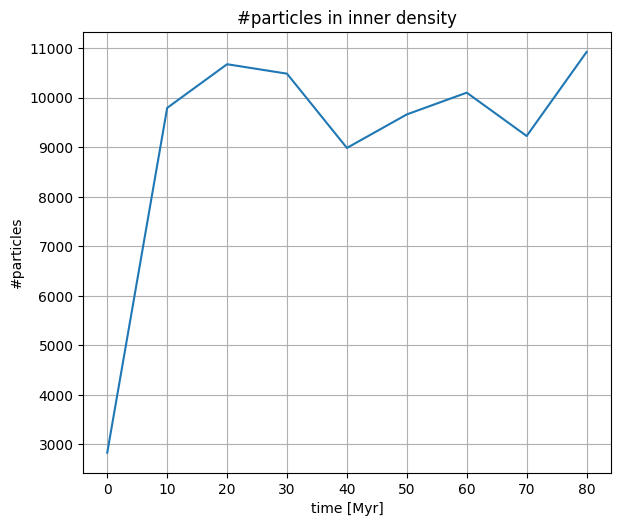

In [21]:
halo.plot_inner_core_density();

In [10]:
halo.saved_states.to_csv('states high amount.csv')

In [34]:
(data.time.unique() <= 12).argmin()

np.int64(68)

In [43]:
from src import nsphere
nsphere.gather_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12550000,tfinal=1100,
                     max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data/results')

,path,save_step,time,record_dtype
106,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,0,0.000000,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
211,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,2,78.107570,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
173,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,4,156.215139,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
114,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,6,234.322709,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
240,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,8,312.430279,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
...,...,...,...,...
39,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,493,19253.515936,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
107,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,495,19331.623506,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
54,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,497,19409.731076,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
205,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,499,19487.838645,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."


In [48]:
np.sqrt(Rs**3/(G*Mtot_dm))

np.float64(17.833703762020537)

In [46]:
40/halo.Tdyn

np.float64(2.2429440644397047)

In [61]:
from matplotlib.colors import PowerNorm
norm=PowerNorm(gamma=3/4,vmin=vmin,vmax=vmax)

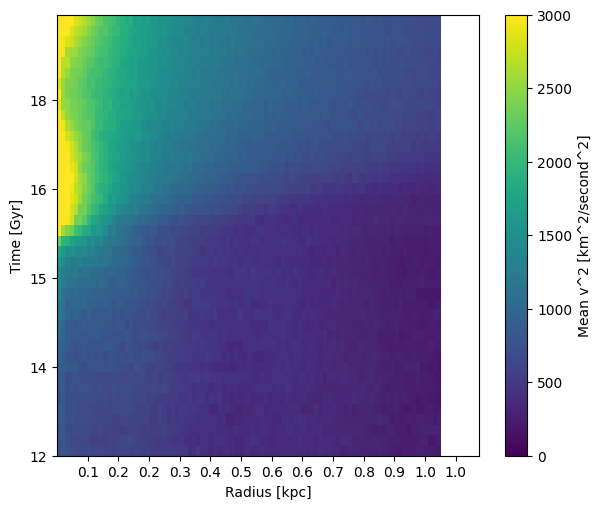

In [97]:
data = halo.saved_states.copy()
data['output'] = (data.v_norm/(km/second))**2
time_units={'name':'Gyr','value':Gyr}
length_units={'name':'kpc','value':kpc}
grid,extent = halo.prep_2d_data(data,radius_cutoff=1*kpc,x_units=length_units,time_units=time_units,agg_fn='mean')

grid = grid[68:]
extent = (extent[0],extent[1],12,extent[3])

plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='Mean v^2 [km^2/second^2]',
        x_nbins=15,x_tick_format='%.1f');

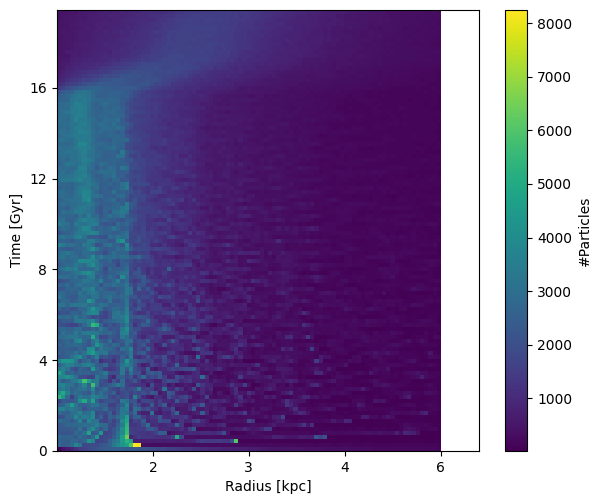

In [13]:
halo.plot_density_evolution(radius_cutoff=6*kpc,time_units={'name':'Gyr','value':Gyr});

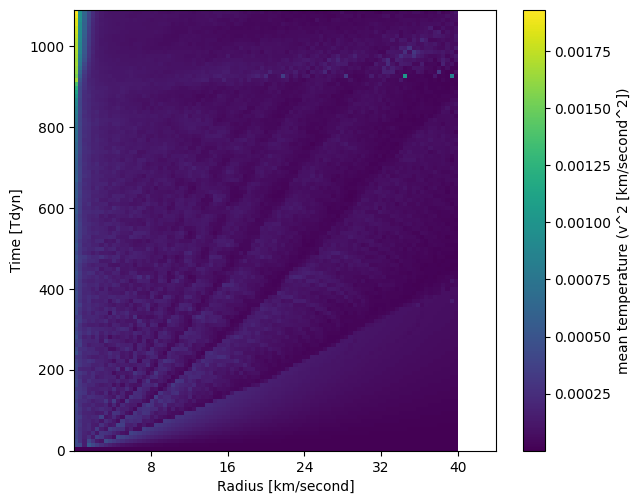

In [51]:
halo.plot_temperature();

## dm plots

In [8]:
data = nsphere.to_saved_state_like(nsphere.load_all_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
                                                          max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data'))

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:01<00:00, 346.59it/s]


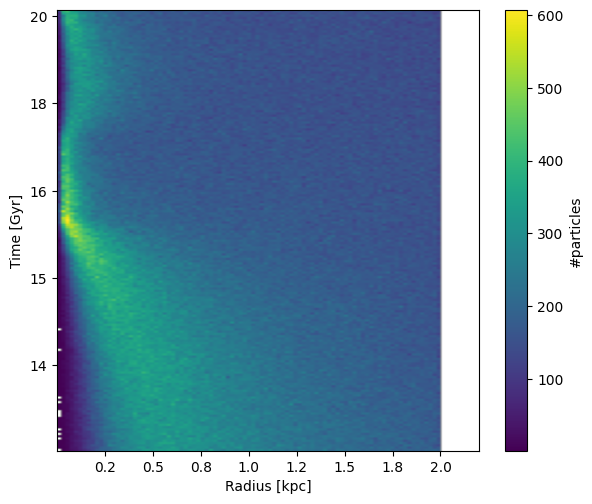

In [17]:
data['output'] = (data.v_norm/(km/second))**2
time_units={'name':'Gyr','value':Gyr}
length_units={'name':'kpc','value':kpc}
grid,extent = halo.prep_2d_data(data,radius_range=(0,2*kpc),time_range=(12*Gyr,20*Gyr),x_units=length_units,time_units=time_units,agg_fn='count')

utils.plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='#particles',
              x_nbins=10,x_tick_format='%.1f');

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  agg_data = pd.concat([agg_data,pad]).drop_duplicates(['time','bin']).sort_values(['time','bin'])


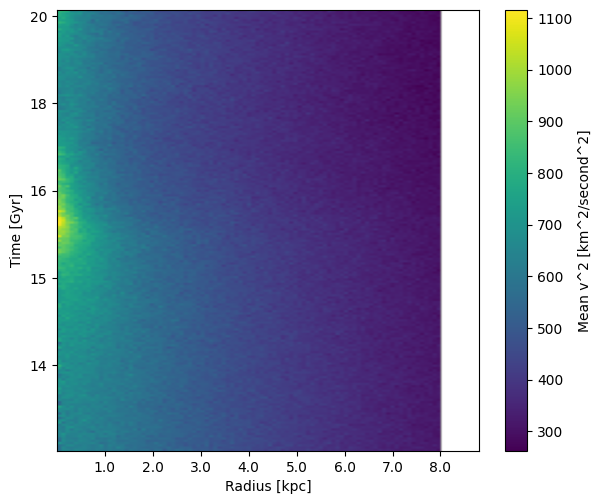

In [26]:
data['output'] = (data.v_norm/(km/second))**2
time_units={'name':'Gyr','value':Gyr}
length_units={'name':'kpc','value':kpc}
grid,extent = halo.prep_2d_data(data,radius_range=(0,8*kpc),x_units=length_units,time_units=time_units,agg_fn='mean')

utils.plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',
              cbar_label='Mean v^2 [km^2/second^2]');

In [68]:
data = nsphere.load_all_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
                              max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data')
data['v^2'] = data['Vrad']**2+(data['L']/data['R'])**2
data['time'] /= Gyr

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:02<00:00, 212.54it/s]


In [72]:
data['Etot'] = data['E'] + data['PsiA']

In [ ]:
agg_data_E = data.groupby('time').E.agg('sum')
agg_data_Etot = data.groupby('time').E_tot.agg('sum')
agg_data_v2 = data.groupby('time')['v^2'].agg('sum')

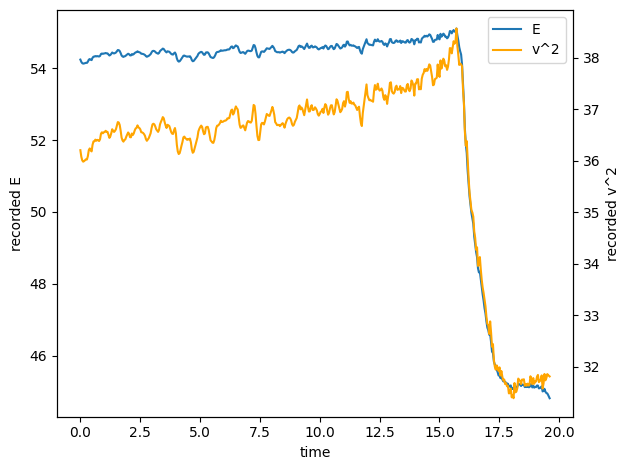

In [70]:
fig,ax1 = plt.subplots()
ax = sns.lineplot(agg_data_E,label='E')
ax1.set_ylabel('recorded E')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()
sns.lineplot(data=agg_data_v2,ax=ax2,color='orange',label='v^2')
ax2.set_ylabel('recorded v^2')
ax2.tick_params(axis='y')

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.get_legend().remove()
ax2.get_legend().remove()
ax1.legend(lines1 + lines2, ['E', 'v^2'], loc='upper right')

# Add title and show
plt.tight_layout()

# Results:

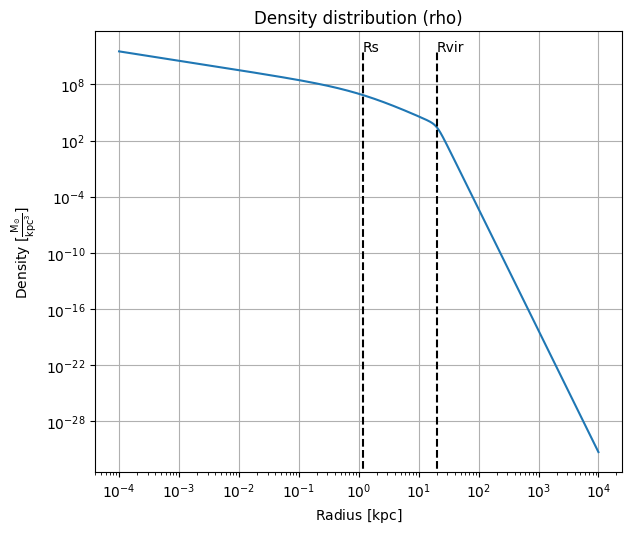

In [5]:
halo.density.plot_rho();

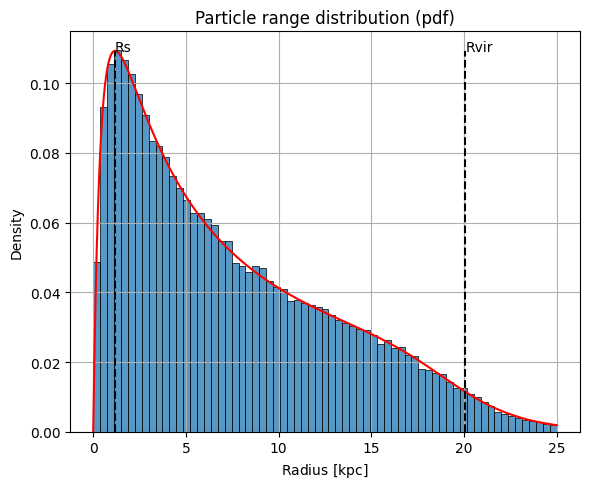

In [6]:
halo.plot_r_distribution(halo.initial_particles,cumulative=False,x_range=units.Quantity([1e-5,25],'kpc'));

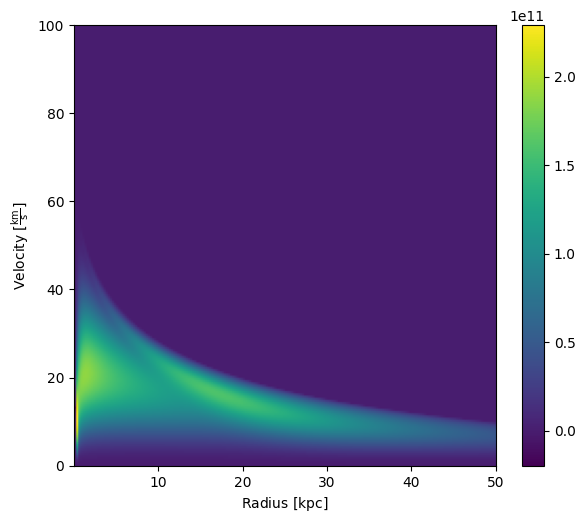

In [7]:
halo.density.plot_phase_space();

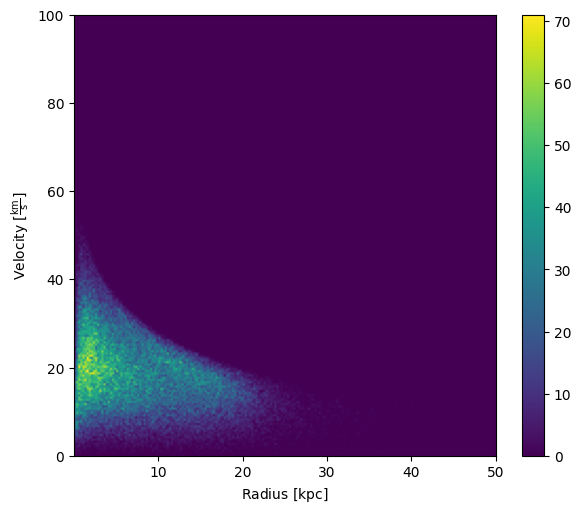

In [8]:
halo.plot_phase_space(halo.initial_particles);